## Baseline
- Data is imbalanced, only 1.7% flights are cancelled.
- False negative is more costly than false positive. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import math
from sklearn.metrics import log_loss
from sklearn.calibration import CalibrationDisplay
from category_encoders import woe
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

e = math.e
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (15,7)

In [2]:
%env GOOGLE_APPLICATION_CREDENTIALS=credentials.json
%load_ext google.cloud.bigquery

env: GOOGLE_APPLICATION_CREDENTIALS=credentials.json


## Read In Train and Validation datasets

In [3]:
%%bigquery train
SELECT *
FROM airlines_raw.train_final

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15799276/15799276 [00:13<00:00, 1202999.72rows/s]


In [4]:
%%bigquery valid
SELECT *
FROM airlines_raw.valid_final

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4771453/4771453 [00:04<00:00, 1103094.52rows/s]


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15799276 entries, 0 to 15799275
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   DAY_OF_WEEK     object 
 1   FLIGHT_WEEK     object 
 2   UNIQUE_CARRIER  object 
 3   ORIGIN          object 
 4   DEST            object 
 5   DISTANCE_MILES  float64
 6   CANCELLED       int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 843.8+ MB


In [6]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4771453 entries, 0 to 4771452
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   DAY_OF_WEEK     object 
 1   FLIGHT_WEEK     object 
 2   UNIQUE_CARRIER  object 
 3   ORIGIN          object 
 4   DEST            object 
 5   DISTANCE_MILES  float64
 6   CANCELLED       int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 254.8+ MB


## Baseline Model
- Predict empirical cancel probability

In [7]:
train_cancel_p = np.round(np.sum(train["CANCELLED"] == 1) / len(train["CANCELLED"]), 3)
print(f"Train Positive = {train_cancel_p}")

Train Positive = 0.017


In [8]:
y_true = valid["CANCELLED"].values
y_pred = np.full(shape=(len(y_true),), fill_value=train_cancel_p)

assert y_true.shape == y_pred.shape

valid_e = log_loss(y_true, y_pred)
print(f"Validation Log Loss = {np.round(valid_e, 3)}")

Validation Log Loss = 0.066


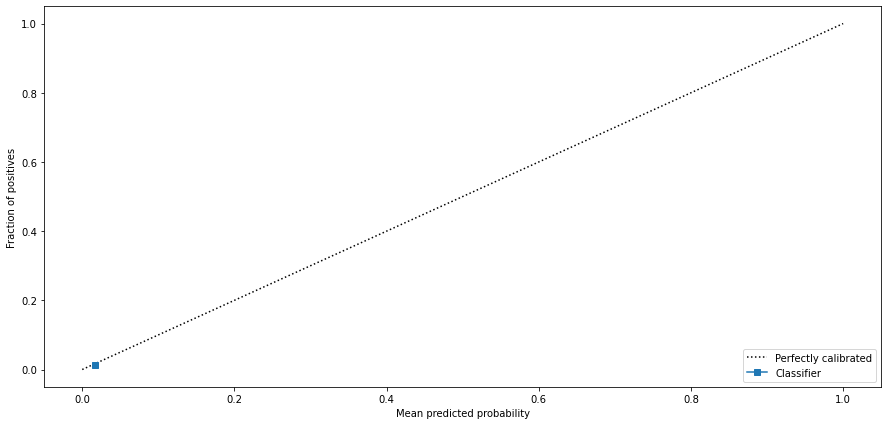

In [9]:
CalibrationDisplay.from_predictions(y_true, y_pred);

This model predicts the probability of cancellation as 1.7% for all flights. As expected, the result is well-calibrated because the baseline just predicted the overall cancellation rate. 
This makes sense for a flight that is not cancelled, but what about the cancelled flights? To see that, we need to look at precision and recall performance, as this data is highly imbalanced.

## Classification with threshold based on empirical probability

In [11]:
from sklearn.metrics import precision_score, recall_score

threshold = train_cancel_p
y_class = y_pred >= threshold
y_class = y_class.astype(int)

recall = recall_score(y_true, y_class)
precision = precision_score(y_true, y_class)
print(f"Recall = {round(recall, 2)}, Precision = {round(precision, 2)}")

Recall = 1.0, Precision = 0.01


If we decide a flight will be cancelled if probability of cancellation is >= empirical probability, then as expected, we detect all positives. But, the precision is very low, because we have a higly imbalanced dataset where only 1.7% of flights are cancelled. So out of all positive samples, we are only right 0.1 times. This mean, if we act on this model, we would keep on rescheduling the meetings indefinitely!
Ideally, we should have the highest recall rate possible without having too many false positives.

- I will compare various logistic regression and NN models as both of them are capable of predicting the probabilities.
- Performance metric: Distance between true value and probability: log loss